# Traffic Sign Classification

## Project Requirements
- Reliably detect Traffic signs
- Get Accuracy more than 0.93

## Approach
- Using LeNet as the base 
- Trying grayscale images first to see if it is reliable enough
- Modify the input layer/ Add a layer before the input layer of the LeNet Architecture to accomodate rgb image


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



training_file = "data/train.p"
validation_file= "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']



---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

# Data
Pickled data downloaded from [this link](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip)

> Data contains three pickle files,
> - train.p - Training Data , Size 34799 
> - test.p - Test Data, Size 12630
> - valid.p - Validation Data, Size 12630

Each file has an input image(X) and output label(Y)
> - X - size,32,32,3 
> - Y - size,1 

Sample of the input data and description of the data is printed and plotted below

Size of training Data = 34799
Size of testing Data = 12630
Size of validation Data = 12630
Image shape = (34799, 32, 32, 3)
Number of classes = 43


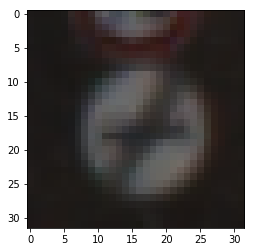

In [2]:


# Data Exploration
#Number of training examples
n_train = len(y_train)
#Number of testing examples.
n_test = len(y_test)
#Shape of an traffic sign image
image_shape = X_train.shape
# Number of unique classes/labels in the dataset.
n_classes = len(np.unique(y_train))

img_size=X_train.shape[1] #Size of input images

print("Size of training Data =", n_train)
print("Size of testing Data =", n_test)
print("Size of validation Data =", n_test)
print("Image shape =", image_shape)
print("Number of classes =", n_classes)

plt.imshow(X_train[0])

# Data Visualization


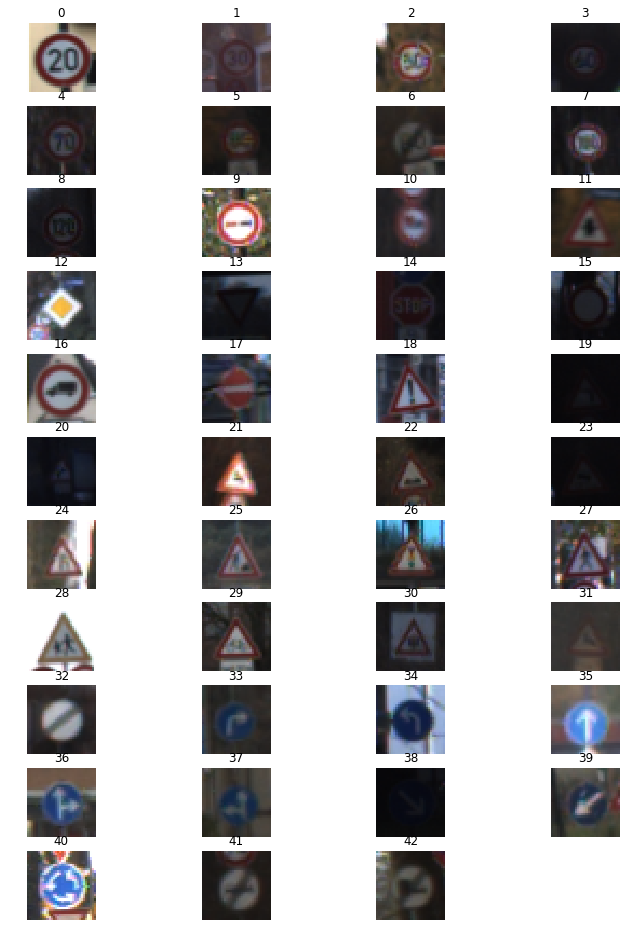

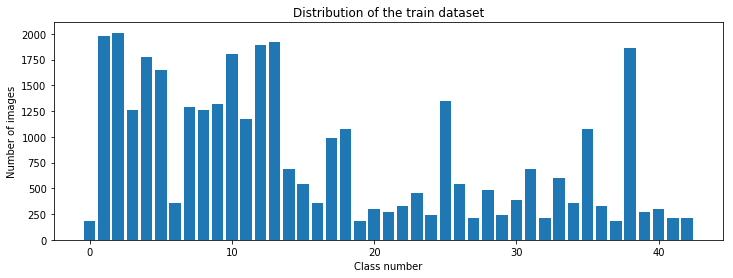

Min number of images per class = 180
Max number of images per class = 2010


In [3]:
### Data exploration visualization goes here.
# Visualizations will be shown in the notebook.

num_of_samples=[]
plt.figure(figsize=(12, 16.5))
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(i)
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()

#Plot number of images per class
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

print("Min number of images per class =", min(num_of_samples))
print("Max number of images per class =", max(num_of_samples))


# Observation
The image data looks noisy and blurry. So let's try the raw data in the model and see the performance before we do any preprocessing. The model is not expected to perform well. 

Generating new data.
Additional data generated. Any classes lacking data now have 809 pictures.
The updated number of training examples = 46714


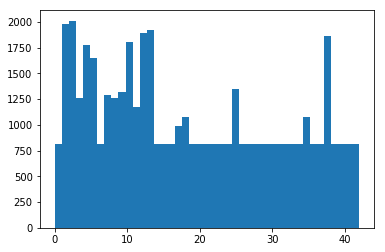

In [4]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# I will generate some additional data, then split the data in a later cell.
# This is to help with the issue identified in the original histogram
from scipy import ndimage
import random

# min_desired below is just mean_pics but wanted to make the code below easier to distinguish
pics_in_class = np.bincount(y_train)
mean_pics = int(np.mean(pics_in_class))
min_desired = int(mean_pics)

print('Generating new data.')

# Angles to be used to rotate images in additional data made
angles = [-10, 10, -15, 15, -20, 20]

# Iterate through each class
for i in range(len(pics_in_class)):
    
    # Check if less data than the mean
    if pics_in_class[i] < min_desired:
        
        # Count how many additional pictures we want
        new_wanted = min_desired - pics_in_class[i]
        picture = np.where(y_train == i)
        more_X = []
        more_y = []
        
        # Make the number of additional pictures needed to arrive at the mean
        for num in range(new_wanted):
            
            # Rotate images and append new ones to more_X, append the class to more_y
            more_X.append(ndimage.rotate(X_train[picture][random.randint(0,pics_in_class[i] - 1)], random.choice(angles), reshape=False))
            more_y.append(i)
        
        # Append the pictures generated for each class back to the original data
        X_train = np.append(X_train, np.array(more_X), axis=0)
        y_train = np.append(y_train, np.array(more_y), axis=0)
        
print('Additional data generated. Any classes lacking data now have', min_desired, 'pictures.')

plt.hist(y_train, bins = n_classes)

updated_n_train = len(X_train)
print("The updated number of training examples =", updated_n_train)


## Step 2: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the German Traffic Sign Dataset.

There are various aspects to consider when thinking about this problem:

Neural network architecture
Play around preprocessing techniques (normalization, rgb to grayscale, etc)
Number of examples per label (some have more than others).
Generate fake data.
Here is an example of a published baseline model on this problem. It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

NOTE: The LeNet-5 implementation shown in the classroom at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation notes
 - Data seems to be not uniform for certain classes, So performed data augmentation by rotating the images.
 - Built a CNN to match the image input 32x32x3, and added dropout layers for better training of the model.
 - 
Build CNN withour size image is : 32x32x3.
Train the CNN. For this I created TrafficSignCalassifierNet class with train public method as this should be cleaner implementation and better than inline coding style.
Test on new images. Again we will be using TrafficSignCalassifierNet and predict public method to classify the image.
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Explaining ImagePreprocessor

Calculate how many images in one traffic sign
For each data set, I generate new images randomly based on current total images
Calculate the average and based on that average, we can estimate how many images needed for each traffic sign
First, separate each traffic sign training set into different arrays
Second, for each data set, I generate new images randomly based on current total images
ImagePreprocessor uses ImageEffect class to generate random effects like rotate, blur, shear, gomma and translate shape.
# CNN Architecture
Using LeNet as the base for the project. Taking it from the [example](https://github.com/udacity/CarND-LeNet-Lab) 

## Import TensorFlow and Preprocess Data

Shuffle the training data. Configure training parameters. 

In [5]:
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
X_train, y_train = shuffle(X_train, y_train)

X_train = X_train / 255 

EPOCHS = 100
BATCH_SIZE = 256

In [6]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)

    # Layer 2: Convolutional. Output = 28x28x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2   = tf.nn.relu(conv2)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Layer 3: Convolutional. Iutput = 14x14x32. Output = 12x12x64
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3   = tf.nn.relu(conv3)

    # Layer 4: Convolutional. Iutput = 12x12x64. Output = 10x10x64
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4   = tf.nn.relu(conv4)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv4 = tf.nn.dropout(conv4, keep_prob)

    # Layer 5: Convolutional. Iutput = 5x5x64. Output = 3x3x128
    conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv5_b = tf.Variable(tf.zeros(128))
    conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='VALID') + conv5_b
    conv5   = tf.nn.relu(conv5)

    # Flatten. Input = 3x3x128. Output = 1152.
    fc0   = flatten(conv5)

    # Layer 3: Fully Connected. Input = 2048. Output = 1024.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1152, 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 1024. Output = 1024.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(1024))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 1024. Output = 43.
    fc3_W       = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean = mu, stddev = sigma))
    fc3_b       = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    return logits

In [7]:

tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.0009
kp = 0.85
keep_prob = tf.placeholder(tf.float32)
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: kp})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.808

EPOCH 2 ...
Validation Accuracy = 0.901

EPOCH 3 ...
Validation Accuracy = 0.930

EPOCH 4 ...
Validation Accuracy = 0.920

EPOCH 5 ...
Validation Accuracy = 0.939

EPOCH 6 ...
Validation Accuracy = 0.931

EPOCH 7 ...
Validation Accuracy = 0.943

EPOCH 8 ...
Validation Accuracy = 0.945

EPOCH 9 ...
Validation Accuracy = 0.944

EPOCH 10 ...
Validation Accuracy = 0.946

EPOCH 11 ...
Validation Accuracy = 0.940

EPOCH 12 ...
Validation Accuracy = 0.953

EPOCH 13 ...
Validation Accuracy = 0.944

EPOCH 14 ...
Validation Accuracy = 0.943

EPOCH 15 ...
Validation Accuracy = 0.964

EPOCH 16 ...
Validation Accuracy = 0.944

EPOCH 17 ...
Validation Accuracy = 0.966

EPOCH 18 ...
Validation Accuracy = 0.949

EPOCH 19 ...
Validation Accuracy = 0.946

EPOCH 20 ...
Validation Accuracy = 0.948

EPOCH 21 ...
Validation Accuracy = 0.954

EPOCH 22 ...
Validation Accuracy = 0.946

EPOCH 23 ...
Validation Accuracy = 0.959

EPOCH 24 ...
Validation Accura

In [9]:
#good values lr = 0.0009,kb = 0.85, batch = 256, epoch - 200
import os
import cv2

test_images = []
test_y = np.array([29,9,36,25,28])
path = './test/'
prediction = tf.argmax(logits, 1)



for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_images.append(img)
              
test_images = np.array(test_images)
output = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    
    test_accuracy = evaluate(X_test, y_test)
    #realImage_accuracy = evaluate(test_images, test_y)
    output = sess.run(prediction,feed_dict={x:test_images,keep_prob:1.0})
    print(output)
    #print(X_test.shape)
    #print(X_test[0],y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


[12  1 13 23 14 13  0 14 25 38 25 14 13 38  0 28 34  0 17 35]
Test Accuracy = 0.939


(20, 32, 32, 3)


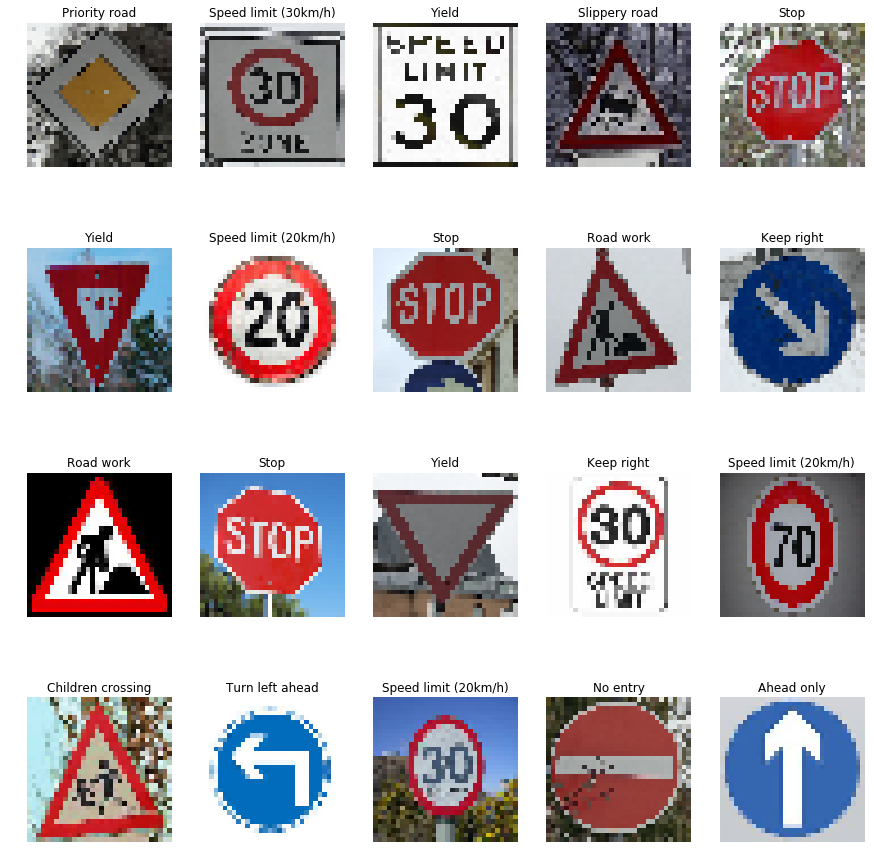

In [11]:
import csv
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

signnames = {}

with open('signnames.csv', 'rt') as csvfile:
    signreader = csv.reader(csvfile)
    for x in signreader:
        signnames[x[0]] = x[1]

test_images = []
path = './test/'

plt.figure(figsize=(15, 20))

for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_images.append(img)
              
test_images = np.array(test_images)
test_images = test_images/255
print(test_images.shape)
for i, image in enumerate(test_images):
    grid = plt.subplot(len(test_images)/4,5,i+1)
    grid.imshow(image), plt.axis('off')
    grid.set_title(signnames[str(output[i])])


plt.show()

# Example